In [ ]:
!nvidia-smi

In [ ]:
!pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2 --quiet
!pip install transformers==4.5.1 --quiet

In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertModel, AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
# from transformers import AutoTokenizer, AutoModel

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42
INFO:lightning:Global seed set to 42


42

In [ ]:
train_path = "YOUR_TRAINING_PATH"
train_raw = pd.read_csv(train_path, sep='#')
test_path = "YOUR_TESTING_PATH"
test_raw = pd.read_csv(test_path, sep='#')
val_path = "YOUR_VAL_PATH"
val_raw = pd.read_csv(val_path, sep='#')

In [ ]:
def preprocess(df):
  removed_cols = ['Unnamed: 0',
                  'Unnamed: 0.1',
 'CVE Page',
 'Summary',
 'Vulnerability Classification',
 'codeLink',
 'commit_id',
 'commit_message',
 'del_lines',
 'file_name',
 'func_before',
# 'processed_func,'
 'vul_func_with_fix',
 'flaw_line',
 'flaw_line_index',
 'vul_func_with_fix',
 'processed_func',
 'sql',
 'r.spl.',
 'dir.',
 'trav.',
 'http',
 'xss',
 'corr.',
 'cpg']
  
  try:
      df = df.rename({'processed_func' : 'text', '+info': 'info', '+priv': 'priv', 'mem.' : 'mem'}, axis=1, inplace=False)
  except:
      print("RENAMED")

  for c in removed_cols:
    try:
      df = df.drop(c, axis=1)
    except:
      print(c)
  df = df.drop('code', axis=1)
  return df

In [ ]:
train_df = preprocess(train_raw)
test_df = preprocess(test_raw)
val_df = preprocess(val_raw)
LABEL_COLUMNS = train_df.columns.tolist()[2:]

In [ ]:
MAX_TOKEN_COUNT = 512
N_EPOCHS = 10
BATCH_SIZE = 32
BERT_MODEL_NAME = "microsoft/codebert-base"
bert_model = AutoModel.from_pretrained("microsoft/codebert-base")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)


In [ ]:
sample_row = test_df.iloc[16]
sample_text = sample_row['text']
sample_labels = sample_row['labels']

In [ ]:
encoding = tokenizer.encode_plus(
  sample_text,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
encoding.keys()

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

In [ ]:
encoding["attention_mask"].squeeze()[:20]

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

## Preprocessing

Let's look at the distribution of the labels:

In [ ]:
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

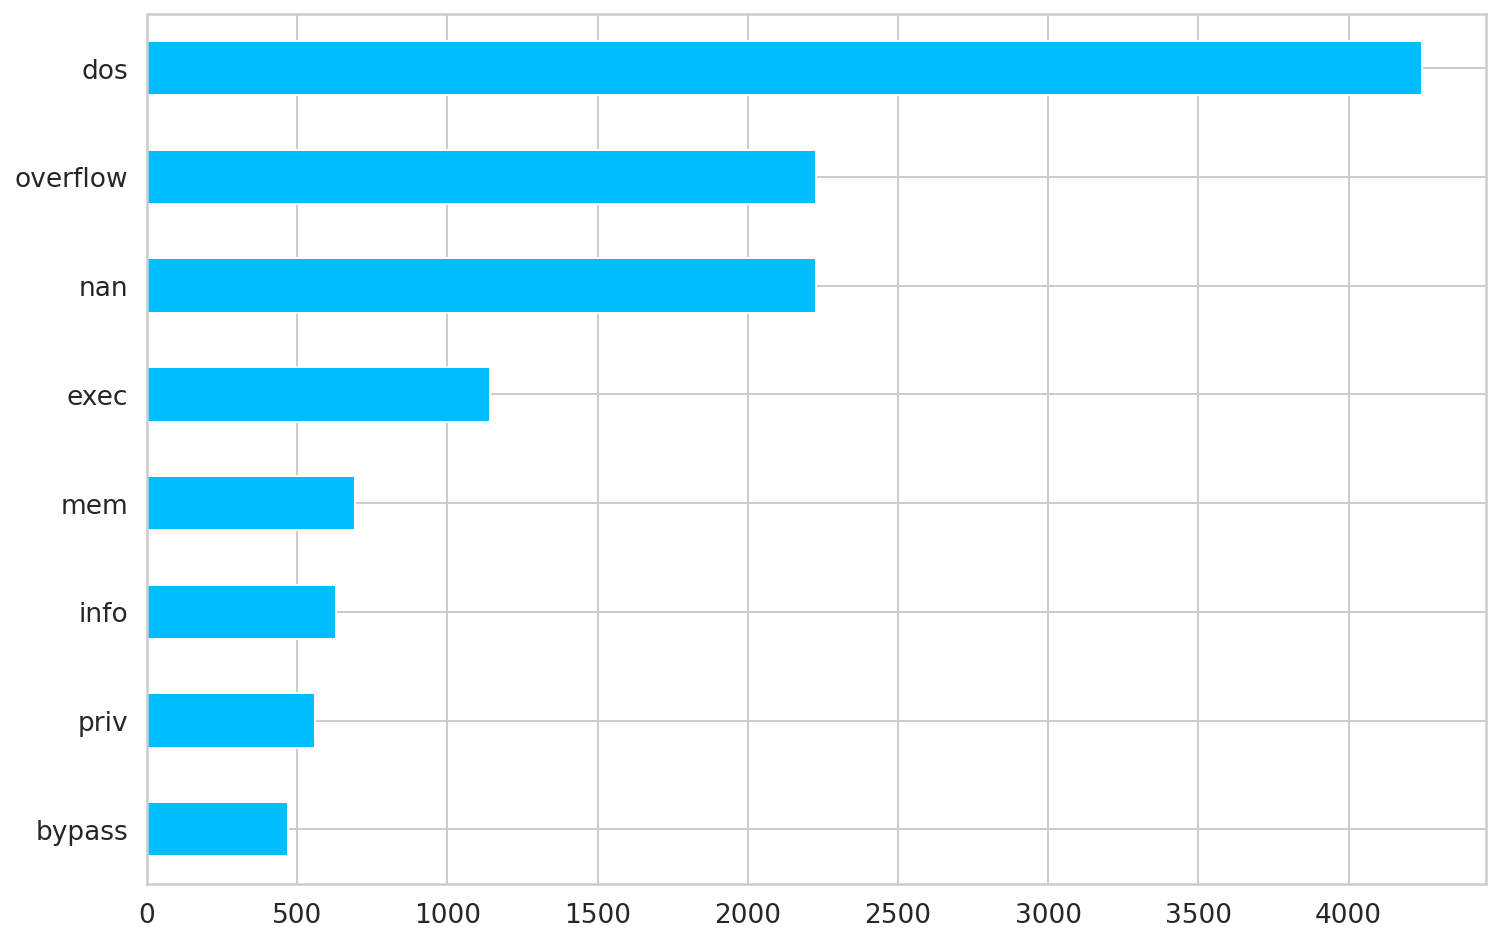

In [ ]:
train_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [ ]:
class VulDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer.from_pretrained("microsoft/codebert-base"),
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    text = data_row.text
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      text=text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
train_dataset = VulDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()

In [ ]:
bert_model.config.hidden_size

In [ ]:
class VulDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=512):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = VulDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = VulDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
BATCH_SIZE = 12
data_module = VulDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE
)

In [ ]:
class VulTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1456, 7280)

In [ ]:
model = VulTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


## Training

In [ ]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="YOUR_BEST_PATH",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="vul-types")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=20
)

In [ ]:
trainer.fit(model, data_module)

In [ ]:
trainer.test()

## Predictions

In [ ]:
LABEL_COLUMNS

['info', 'priv', 'bypass', 'dos', 'exec', 'mem', 'nan', 'overflow']

In [ ]:
trained_model = VulTagger.load_from_checkpoint(
  "YOUR_BEST",
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

In [ ]:
test_vul = test_df['text'][1]

encoding = tokenizer.encode_plus(
  test_vul,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
encoding["input_ids"].shape


In [ ]:
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

In [ ]:
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

In [ ]:
THRESHOLD = 0.2

test_vul = test_df['text'][1]
encoding = tokenizer.encode_plus(
  test_vul,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  # padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

In [ ]:
test_df[LABEL_COLUMNS].iloc[[1]]

## Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

test_dataset = VulDataset(
  test_df,
  tokenizer,
  max_token_len=512
)

predictions = []
labels = []

for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())



In [ ]:
labels

In [ ]:
THRESHOLD = YOUR_THRESHOLD
def real(preds, threshold=THRESHOLD):
  real_predictions = []
  for pred in preds:
    if pred >= threshold:
      real_predictions.append(1)
    else:
      real_predictions.append(0)
  return real_predictions
def accuracy_strict_item(preds, lbs):
  assert(len(preds) == len(lbs))
  upper = 0
  lower = 0
  for i in range(len(preds)):
    sum = preds[i] + lbs[i]
    if sum == 2:
      upper = upper+1
      lower = lower+1
    if sum == 1:
      lower = lower+1
  if lower == 0:
    return 0.0
  return upper/lower

def accuracy_strict(predictions, labels, threshold=THRESHOLD):
  sum = 0
  for idx in range(len(predictions)):

    real_pred = real(predictions[idx].numpy(), threshold)
    sum = sum + accuracy_strict_item(real_pred, labels[idx].numpy())
  return sum/len(predictions)

THRESHOLD = 0.4
accuracy_strict(predictions, labels, threshold=THRESHOLD)

0.6651658767772513

In [ ]:
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()
accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
labels

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  try:
    tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
    print(f"{name}: {tag_auroc}")
  except:
    print("ERROR: " + name)

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

In [ ]:
y_pred

In [ ]:
df_preds = pd.DataFrame(y_pred)
df_preds.to_csv("raw_preds.csv",index=False, header=LABEL_COLUMNS)

In [ ]:
df_labels = pd.DataFrame(y_true)
df_labels.to_csv("labels.csv",index=False, header=LABEL_COLUMNS)

In [ ]:
LABEL_COLUMNS

# TEST DF

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = VulDataset(
  test_df,
  tokenizer,
  max_token_len=512
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
THRESHOLD = 0.6
accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  try:
    tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
    print(f"{name}: {tag_auroc}")
  except:
    print("ERROR: " + name)

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))